In [2]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers
from scipy import interpolate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
def initial_load(root_folder, folders):
    
    audio_files_pathes = []
    audio_files = []
    transcripts = []
    
    for folder in folders:
        folder_path = os.path.join(root_folder, folder)
        if os.path.exists(folder_path):
                for root, dirs, files in os.walk(folder_path):
                    for file in files:
                        if file.endswith(".mp3"):
                            audio_files_pathes.append(os.path.join(root,file))
                            transcripts.append(file)
                
    for audio_file_path in audio_files_pathes:
        audio, sr = librosa.load(audio_file_path, sr=None) 
        audio_files.append(audio)
    
    return audio_files, sr, np.array(transcripts)

def spectrogram_cast(audio_files):
    spectrograms = []
    
    for audio_file in audio_files:
        spectrogram = librosa.feature.melspectrogram(y=audio_file)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)  
        spectrograms.append(spectrogram)
        
    return spectrograms

def spectrograms_normalization(max_length = None, *spectrograms_arrays):
    spectrograms_normalized = []
    
    max_length_temp = max_length
        
    if max_length == None:    
        max_length = max(max(spec.shape[1] for spec in spectrogram_array) for spectrogram_array in spectrograms_arrays)

    for spec_array in spectrograms_arrays:
        for spec in spec_array:
            spectrogram_empty = np.zeros((128, max_length))
            spectrogram_empty[:, :spec.shape[1]] = spec
            spectrograms_normalized.append(upsample_spectrogram(spectrogram_empty, max_length))

    return (max_length, *split_array(spectrograms_normalized)) if max_length_temp is None else (max_length, spectrograms_normalized)

def upsample_spectrogram(spec, target_length):
    num_freq_bins, num_time_bins = spec.shape
    x_old = np.linspace(0, 1, num_time_bins)
    x_new = np.linspace(0, 1, target_length)
    upsampled_spec = np.zeros((num_freq_bins, target_length))

    for i in range(num_freq_bins):
        f = interpolate.interp1d(x_old, spec[i, :], kind='linear')
        upsampled_spec[i, :] = f(x_new)

    return upsampled_spec

def augment_pitch_shift(audio_files, transcripts, sr, pitch_shift_steps):
    audio_files_pitched = []
    transcripts_modified = []
    
    for index, audio_file in enumerate(audio_files):
        audio_pitch_shifted = librosa.effects.pitch_shift(audio_file, sr, pitch_shift_steps)
        audio_files_pitched.append(audio_pitch_shifted)
        transcripts_modified.append(transcripts[index] + ' SHIFTED')
        
    return audio_files_pitched, transcripts_modified

def augment_noise(audio_files, transcripts, sr, noise_constant = 0.01):
    audio_files_noised = []
    transcripts_modified = []
    
    for index, audio_file in enumerate(audio_files):
        audio_noised = audio_file + noise_constant * np.random.normal(0, 1, len(audio_file))
        audio_files_noised.append(audio_noised)
        transcripts_modified.append(transcripts[index] + ' NOISED')
        
    return audio_files_noised, transcripts_modified

def pretrain_normalization(transcripts, *spectrograms_arrays):
    spectrograms = []
    output_transcripts = []
    
    label_encoder = LabelEncoder()
    encoded_transcripts = label_encoder.fit_transform(transcripts)
    
    for spectrogram_array in spectrograms_arrays:
        for index, spectrogram in enumerate(spectrogram_array):
            spectrograms.append(spectrogram/255.0)
        output_transcripts.extend(encoded_transcripts)
            
    return np.array(spectrograms), np.array(output_transcripts), label_encoder

def pretest_normalization(specs):
    spectrograms = []
    
    for spec in specs:
        spectrograms.append(spec/255.0)
    
    return np.array(spectrograms)

def spectrograms_plot(spectrograms, transcripts, cols, sr, name='spectrograms.png', limit=2):
    plt.figure(figsize=(15, 10))
    num_spec = min(limit, len(spectrograms))
    num_cols = cols  
    num_rows = (num_spec - 1) // num_cols + 1 
    
    for i in range(num_spec):
        plt.subplot(num_rows, num_cols, i + 1)
        librosa.display.specshow(spectrograms[i], sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(transcripts[i])

    plt.tight_layout()
    plt.savefig(name)
    plt.show()

def split_array(arr):
    middle_index = len(arr) // 2
    first_half = arr[:middle_index]
    second_half = arr[middle_index:]
    return first_half, second_half

In [3]:
root_folder = r'C:\Users\SergeySaber\Desktop\AI works\university\labs\1. tts\resources'

pics_folder = "C:\\Users\\SergeySaber\\Desktop\\AI works\\university\\labs\\1. tts\\demo\\"

initial_folders = ["lovo", "voicerss"]
crossed_folders = ["lovo_crossed", "voicerss_crossed"]

In [4]:
initial_audio_files, sr, initial_transcripts = initial_load(root_folder, initial_folders)
crossed_audio_files, sr, crossed_transcripts = initial_load(root_folder, crossed_folders)

In [5]:
initial_audio_spectrograms = spectrogram_cast(initial_audio_files)
crossed_audio_spectrograms = spectrogram_cast(crossed_audio_files)

In [6]:
max_length, initial_audio_spectrograms_normalized, crossed_audio_spectrograms_normalized = spectrograms_normalization(None, initial_audio_spectrograms, crossed_audio_spectrograms)

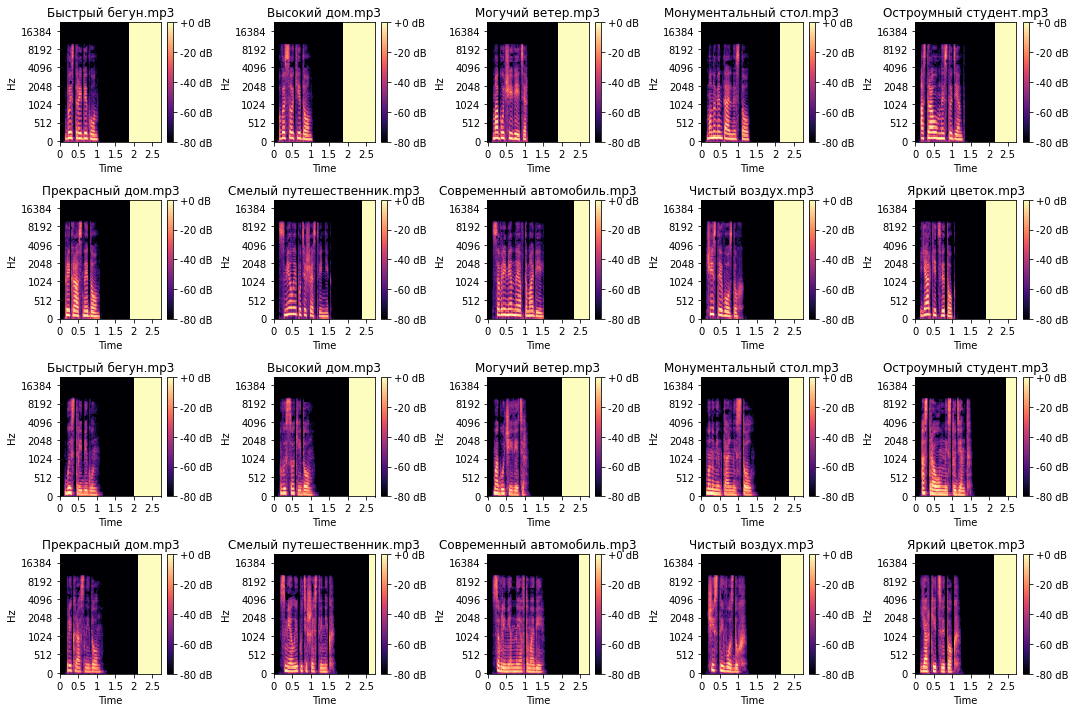

In [7]:
spectrograms_plot(initial_audio_spectrograms_normalized, initial_transcripts, 5, sr, os.path.join(pics_folder,'initial_audio_spectrograms_normalized.jpeg'), 20)

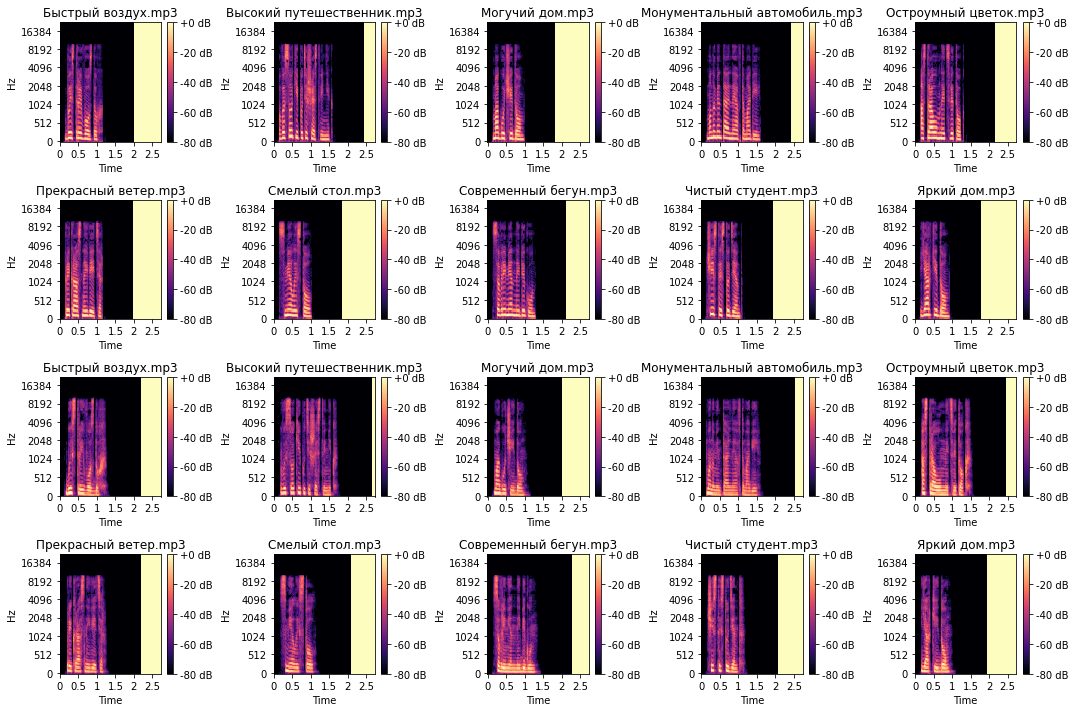

In [8]:
spectrograms_plot(crossed_audio_spectrograms_normalized, crossed_transcripts, 5, sr, os.path.join(pics_folder,'crossed_audio_spectrograms_normalized.jpeg'), 20)

<ipython-input-2-b6c258ce9104>:65: FutureWarning: Pass sr=44100, n_steps=2.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_pitch_shifted = librosa.effects.pitch_shift(audio_file, sr, pitch_shift_steps)
<ipython-input-2-b6c258ce9104>:65: FutureWarning: Pass sr=44100, n_steps=2.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_pitch_shifted = librosa.effects.pitch_shift(audio_file, sr, pitch_shift_steps)


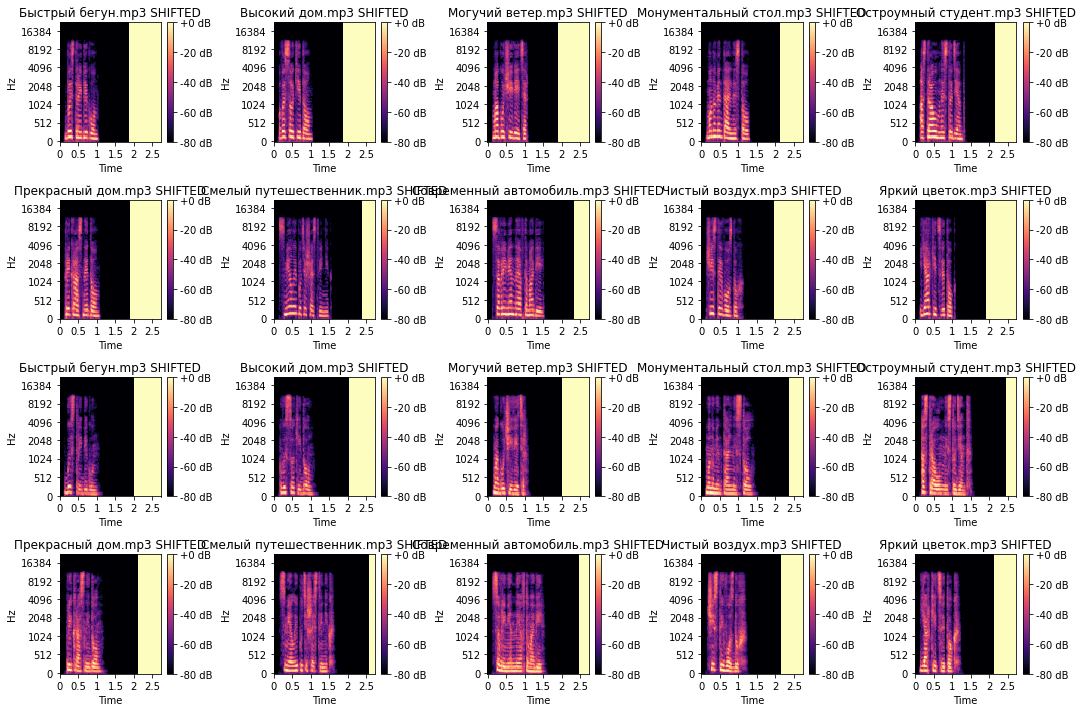

In [9]:
pitch_shifted_audio_files, pitch_shifted_transcripts = augment_pitch_shift(initial_audio_files, initial_transcripts, sr, 2.0)

pitch_shifted_audio_spectrograms = spectrogram_cast(pitch_shifted_audio_files)
_, pitch_shifted_audio_spectrograms_normalized = spectrograms_normalization(max_length, pitch_shifted_audio_spectrograms)
spectrograms_plot(pitch_shifted_audio_spectrograms_normalized, pitch_shifted_transcripts, 5, sr, os.path.join(pics_folder,'pitch_shiftet_audio_spectrograms_normalized.jpeg'), 20)

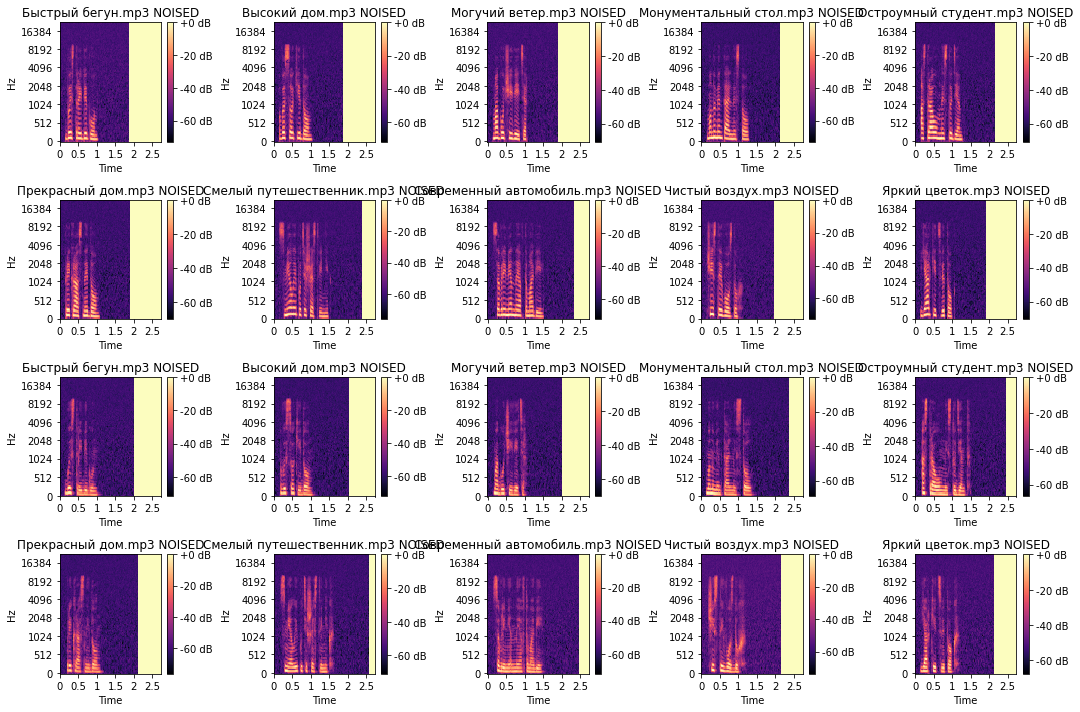

In [10]:
noised_audio_files, noised_transcripts = augment_noise(initial_audio_files, initial_transcripts, sr, 0.005)

noised_audio_spectrograms = spectrogram_cast(noised_audio_files)
_, noised_audio_spectrograms_normalized = spectrograms_normalization(max_length, noised_audio_spectrograms)
spectrograms_plot(noised_audio_spectrograms_normalized, noised_transcripts, 5, sr, os.path.join(pics_folder,'noised_audio_spectrograms_normalized.jpeg'), 20)

In [11]:
X, y, label_encoder = pretrain_normalization(initial_transcripts, initial_audio_spectrograms_normalized, pitch_shifted_audio_spectrograms_normalized, noised_audio_spectrograms_normalized)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(len(np.unique(y_train)) + 1, activation='softmax')) 

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=25, batch_size=8, verbose=1, validation_data=(X_val, y_val))

Epoch 1/25
18/18 [==============================] - 3s 30ms/step - loss: 2.4110 - accuracy: 0.0833 - val_loss: 2.3802 - val_accuracy: 0.2222
Epoch 2/25
18/18 [==============================] - 0s 17ms/step - loss: 2.3434 - accuracy: 0.1111 - val_loss: 2.3052 - val_accuracy: 0.1944
Epoch 3/25
18/18 [==============================] - 0s 16ms/step - loss: 2.1785 - accuracy: 0.2083 - val_loss: 2.1345 - val_accuracy: 0.2500
Epoch 4/25
18/18 [==============================] - 0s 17ms/step - loss: 1.9599 - accuracy: 0.2847 - val_loss: 1.8270 - val_accuracy: 0.3056
Epoch 5/25
18/18 [==============================] - 0s 16ms/step - loss: 1.6058 - accuracy: 0.4792 - val_loss: 1.4885 - val_accuracy: 0.5000
Epoch 6/25
18/18 [==============================] - 0s 17ms/step - loss: 1.2120 - accuracy: 0.5486 - val_loss: 1.0949 - val_accuracy: 0.5278
Epoch 7/25
18/18 [==============================] - 0s 16ms/step - loss: 0.8379 - accuracy: 0.6875 - val_loss: 0.6695 - val_accuracy: 0.8333
Epoch 8/25
18

In [14]:
X_test = pretest_normalization(crossed_audio_spectrograms_normalized)

In [15]:
predictions = model.predict(X_test)

2/2 [==============================] - 0s 115ms/step


In [16]:
print(crossed_transcripts)

['Быстрый воздух.mp3' 'Высокий путешественник.mp3' 'Могучий дом.mp3'
 'Монументальный автомобиль.mp3' 'Остроумный цветок.mp3'
 'Прекрасный ветер.mp3' 'Смелый стол.mp3' 'Современный бегун.mp3'
 'Чистый студент.mp3' 'Яркий дом.mp3' 'Быстрый воздух.mp3'
 'Высокий путешественник.mp3' 'Могучий дом.mp3'
 'Монументальный автомобиль.mp3' 'Остроумный цветок.mp3'
 'Прекрасный ветер.mp3' 'Смелый стол.mp3' 'Современный бегун.mp3'
 'Чистый студент.mp3' 'Яркий дом.mp3' 'Быстрый воздух.mp3'
 'Высокий путешественник.mp3' 'Могучий дом.mp3'
 'Монументальный автомобиль.mp3' 'Остроумный цветок.mp3'
 'Прекрасный ветер.mp3' 'Смелый стол.mp3' 'Современный бегун.mp3'
 'Чистый студент.mp3' 'Яркий дом.mp3' 'Быстрый воздух.mp3'
 'Высокий путешественник.mp3' 'Могучий дом.mp3'
 'Монументальный автомобиль.mp3' 'Остроумный цветок.mp3'
 'Прекрасный ветер.mp3' 'Смелый стол.mp3' 'Современный бегун.mp3'
 'Чистый студент.mp3' 'Яркий дом.mp3' 'Быстрый воздух.mp3'
 'Высокий путешественник.mp3' 'Могучий дом.mp3'
 'Монумента

In [17]:
all_labels = []
all_labels.extend(crossed_transcripts)
all_labels.extend(initial_transcripts)
print(len(all_labels))
label_encoder = LabelEncoder()
_ = label_encoder.fit(all_labels)

120


In [18]:
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

encoded_transcripts_test = label_encoder.transform(crossed_transcripts)
test_loss, test_accuracy = model.evaluate(X_test, encoded_transcripts_test, verbose=1)

    
# label_encoder.fit_transform(transcripts)
predicted_labels_text = label_encoder.inverse_transform(predicted_labels)


[8 4 5 4 4 3 5 7 8 8 7 6 5 7 4 3 9 3 9 9 2 6 5 3 3 5 5 3 9 5 4 6 2 6 6 3 8
 7 9 2 8 7 0 3 4 8 1 9 5 1 5 4 1 6 9 5 1 9 5 6]
2/2 [==============================] - 0s 16ms/step - loss: nan - accuracy: 0.1000
